In [ ]:
# Install dependencies as needed:
!pip install kagglehub[pandas-datasets] --quiet
!pip install unidecode --quiet

In [ ]:

import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "netflix_titles.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "shivamb/netflix-shows",
  file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

<ipython-input-142-a1ccddea43f5>:8: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  df = kagglehub.load_dataset(


In [ ]:
top_directores = [
    "martin scorsese",
    "james cameron",
    "steven spielberg",
    "christopher nolan",
    "quentin tarantino",
    "tim burton",
]


In [ ]:

import unidecode

def normalize_text(text):
  text = unidecode.unidecode(text) # Quitar tildes
  text = text.lower() # Convertir a minúsculas
  text = text.strip() # Eliminar espacios al principio y al final
  return text

df = df.dropna()
df = df[df['type']=='Movie']               # filtrado por pelicula
df = df[df['country']=='United States']   # filtrado por pais

# Normalizar la lista de directores
normalized_top_directors = [normalize_text(director) for director in top_directores]

# Normalizar la columna 'director' en el DataFrame
df['normalized_director'] = df['director'].apply(normalize_text)

# Filtrar el DataFrame
df = df[df['normalized_director'].isin(normalized_top_directors)]
df = df.head(5)

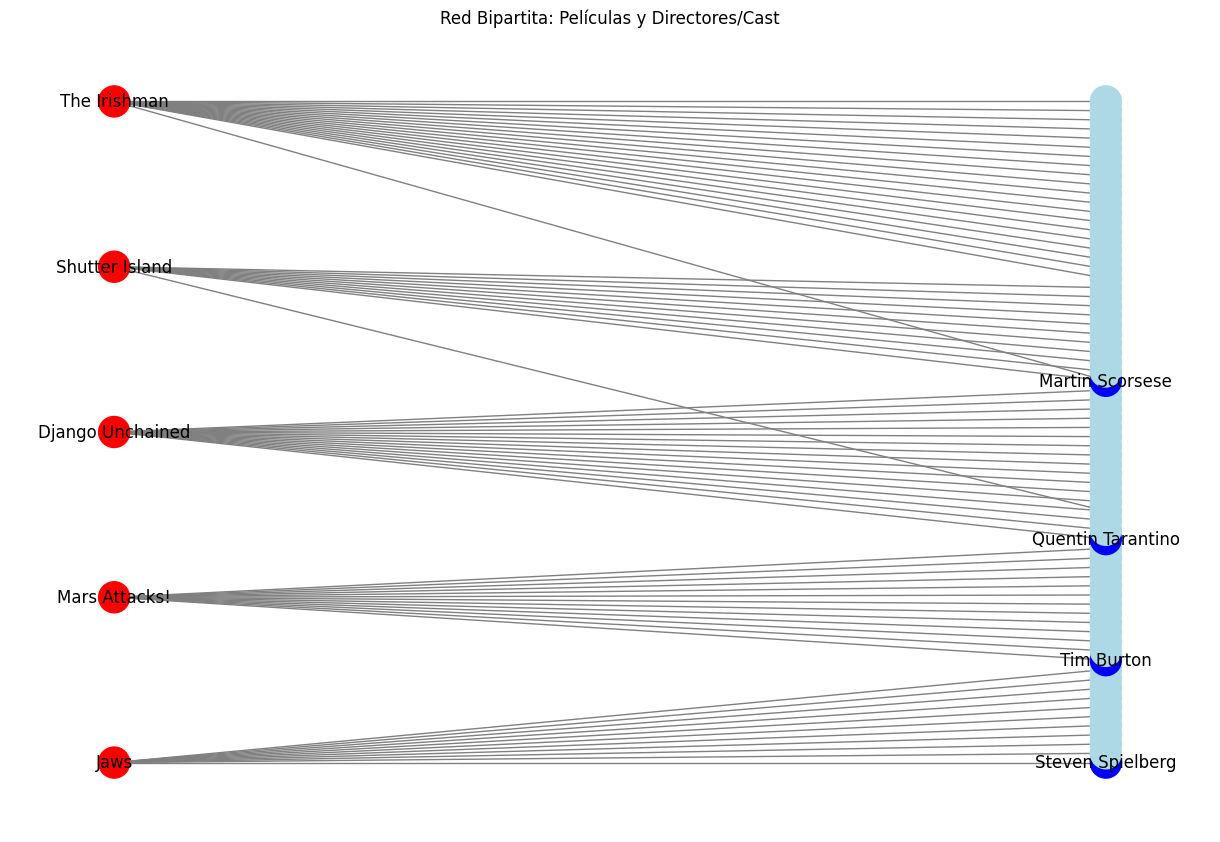

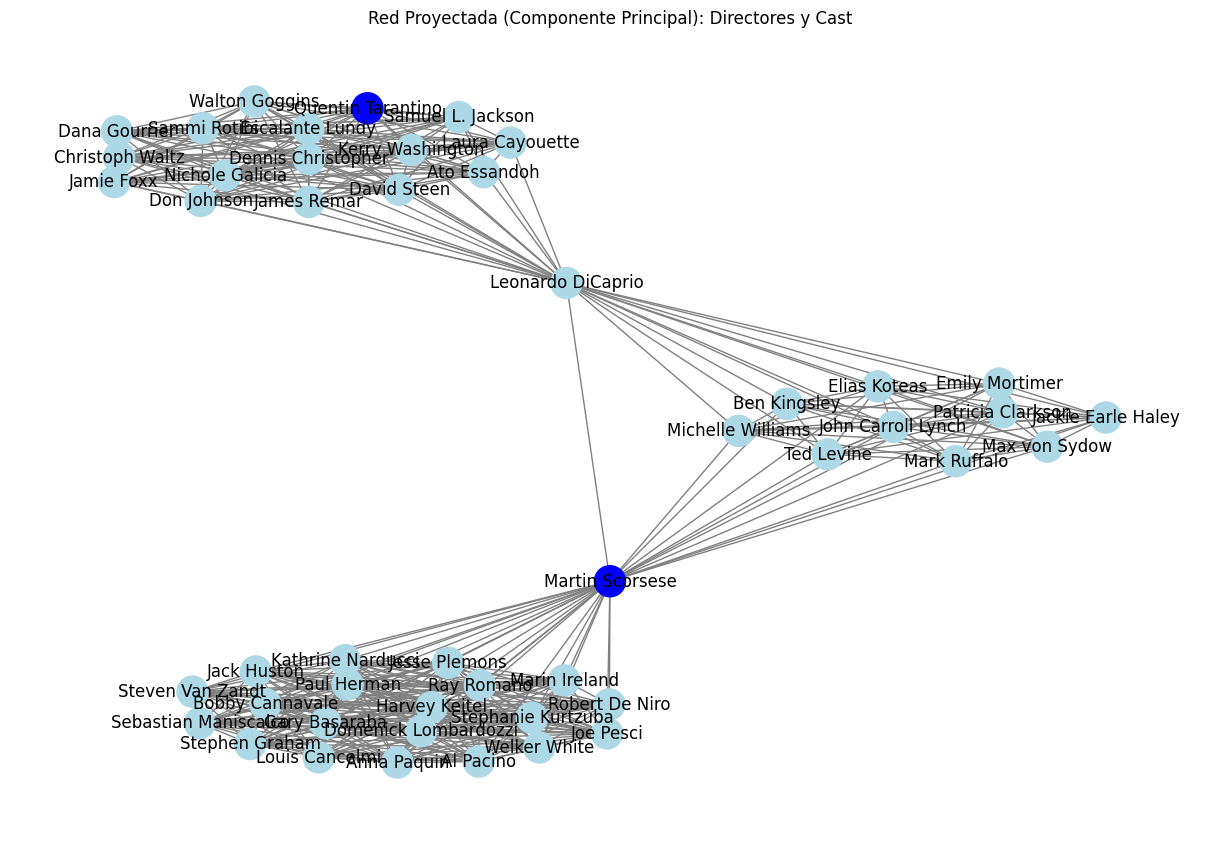

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import re

def clean_text(text):
    return re.sub(r'\$', '', text)

# Creamos el grafo bipartito
G = nx.Graph()

# Iteramos sobre cada fila del DataFrame
for idx, row in df.iterrows():
    try:
        # Obtenemos el título de la película, si es NA o vacío, se omite la fila
        movie = row['title']
        if pd.isna(movie) or str(movie).strip() == "":
            continue
        movie = str(movie).strip()
        if not G.has_node(movie):
            G.add_node(movie, bipartite=0, color='red', label=movie)

        # Procesamos el director
        director = row.get('director', None)
        if pd.notna(director) and str(director).strip() != "":
            director = clean_text(str(director).strip())
            if not G.has_node(director):
                G.add_node(director, bipartite=1, color='blue', label=director, rol='director')
            G.add_edge(movie, director)

        # Procesamos el cast
        cast = row.get('cast', None)
        if pd.notna(cast) and str(cast).strip() != "":
            cast = clean_text(str(cast))
            # Separamos por comas y eliminamos espacios en blanco
            cast_members = [member.strip() for member in cast.split(',') if member.strip() != ""]
            for member in cast_members:
                if not G.has_node(member):
                    G.add_node(member, bipartite=1, color='lightblue', label=member, rol='cast')
                G.add_edge(movie, member)

    except Exception as e:
        print(f"Skipping row {idx} due to error: {e}")
        continue

# Visualización de la red bipartita
movies_nodes = [n for n, d in G.nodes(data=True) if d.get('bipartite') == 0]
pos = nx.bipartite_layout(G, movies_nodes)
node_colors = [d['color'] for _, d in G.nodes(data=True)]
labels = {}

for n, d in G.nodes(data=True):
    # Si el nodo tiene el rol de director, mostramos su label; sino, dejamos la etiqueta en blanco.
    if d.get('rol') == 'director' or d.get('bipartite') == 0:
        labels[n] = d['label']
    else:
        labels[n] = ""
plt.figure(figsize=(12,8))
nx.draw(G, pos, labels=labels, node_color=node_colors, edge_color='gray', node_size=500)
plt.title("Red Bipartita: Películas y Directores/Cast")
plt.show()

# Proyección de la red para obtener la red de directores y cast
person_nodes = [n for n, d in G.nodes(data=True) if d.get('bipartite') == 1]
G_proj = nx.bipartite.weighted_projected_graph(G, person_nodes)

# Seleccionamos la componente principal (la mayor componente conexa)
largest_cc = max(nx.connected_components(G_proj), key=len)
G_proj_sub = G_proj.subgraph(largest_cc).copy()


proj_node_colors = [G.nodes[n]['color'] for n in G_proj_sub.nodes()]

plt.figure(figsize=(12,8))
nx.draw(G_proj_sub, with_labels=True, node_color=proj_node_colors, edge_color='gray', node_size=500)
plt.title("Red Proyectada (Componente Principal): Directores y Cast")
plt.show()

